In [8]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

In [5]:
full_dataset = OpenCloseDataset(datafolder='../data', k_degree=30).shuffle()
len(os.listdir('../data/processed'))

Processing...
Done!


96

In [6]:
train_size = int(0.94 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]
val_dataset, test_dataset = val_dataset[:-3], val_dataset[-3:]

In [21]:
len(val_dataset)

3

In [22]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

class GCN(nn.Module):
    def __init__(self,
                 num_features,
                 num_classes,
                 channels,
                 dropout=0):
        super().__init__()

        self.p = dropout
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.conv3 = GCNConv(channels[1], channels[2])

        self.lin1 = nn.Linear(channels[2], int(num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        #print(x.shape)
        x = F.relu(self.conv1(x, edge_index)) #
        #print(x.shape)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        x = F.relu(self.conv3(x, edge_index))
        #print(x.shape)
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.lin1(x)
        return x

In [10]:
from torch_geometric.nn import GCNConv, GATv2Conv

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=2):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.lin = nn.Linear(dim_out, 2)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = F.elu(self.gat2(h, edge_index))
        h = global_mean_pool(h, data.batch)
        h = self.lin(h)
        return h

In [3]:
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def eval_epoch(loader, model, criterion):
    model.eval()
    losses = 0
    correct = 0
    pr = []
    rc = []
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data)
            loss = criterion(out, data.y)
            losses += loss.item()
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            #print(pred)
            #print(data.y)

            pr.append(precision_score(data.y, pred, zero_division=0))
            rc.append(recall_score(data.y, pred, zero_division=0))
        # Derive ratio of correct predictions.
    return losses / len(loader.dataset), correct / len(loader.dataset), np.mean(pr), np.mean(rc)

def train(model, epochs, train_loader, val_loader, criterion, optimizer):
    losses = []
    for epoch in tqdm(range(1, epochs)):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        losses.append((train_loss, val_loss))
    return losses

In [18]:
from torch.optim import lr_scheduler
model = GCN(full_dataset.num_features, 2, channels=[256, 32, 8], dropout=0.6).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 20
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


116282

In [19]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [20]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer)

  5%|▌         | 1/20 [00:13<04:11, 13.26s/it]

Epoch: 001, Train Loss: 0.0868, Test Loss 0.2246, Train Acc: 0.4545, Test Acc: 0.6667


 10%|█         | 2/20 [00:26<03:53, 12.98s/it]

Epoch: 002, Train Loss: 0.0865, Test Loss 0.2295, Train Acc: 0.5682, Test Acc: 0.6667


 15%|█▌        | 3/20 [00:38<03:34, 12.60s/it]

Epoch: 003, Train Loss: 0.0864, Test Loss 0.2319, Train Acc: 0.5227, Test Acc: 0.3333


 20%|██        | 4/20 [00:57<04:03, 15.24s/it]

Epoch: 004, Train Loss: 0.0861, Test Loss 0.2309, Train Acc: 0.5455, Test Acc: 0.3333


 25%|██▌       | 5/20 [01:16<04:07, 16.47s/it]

Epoch: 005, Train Loss: 0.0856, Test Loss 0.2401, Train Acc: 0.5114, Test Acc: 0.3333


 30%|███       | 6/20 [01:29<03:34, 15.33s/it]

Epoch: 006, Train Loss: 0.0859, Test Loss 0.2276, Train Acc: 0.7614, Test Acc: 1.0000


 35%|███▌      | 7/20 [01:43<03:15, 15.04s/it]

Epoch: 007, Train Loss: 0.0854, Test Loss 0.2301, Train Acc: 0.6250, Test Acc: 0.3333


 40%|████      | 8/20 [01:57<02:54, 14.51s/it]

Epoch: 008, Train Loss: 0.0846, Test Loss 0.2242, Train Acc: 0.7955, Test Acc: 1.0000


 45%|████▌     | 9/20 [02:11<02:38, 14.39s/it]

Epoch: 009, Train Loss: 0.0840, Test Loss 0.2306, Train Acc: 0.6705, Test Acc: 0.3333


 50%|█████     | 10/20 [02:26<02:27, 14.74s/it]

Epoch: 010, Train Loss: 0.0848, Test Loss 0.2024, Train Acc: 0.4886, Test Acc: 0.6667


 55%|█████▌    | 11/20 [02:39<02:07, 14.20s/it]

Epoch: 011, Train Loss: 0.0817, Test Loss 0.2167, Train Acc: 0.7045, Test Acc: 1.0000


 60%|██████    | 12/20 [02:52<01:49, 13.72s/it]

Epoch: 012, Train Loss: 0.0820, Test Loss 0.2230, Train Acc: 0.7500, Test Acc: 0.6667


 65%|██████▌   | 13/20 [03:05<01:34, 13.51s/it]

Epoch: 013, Train Loss: 0.0859, Test Loss 0.2510, Train Acc: 0.5341, Test Acc: 0.3333


 70%|███████   | 14/20 [03:18<01:20, 13.48s/it]

Epoch: 014, Train Loss: 0.0828, Test Loss 0.2258, Train Acc: 0.7159, Test Acc: 0.3333


 75%|███████▌  | 15/20 [03:36<01:13, 14.63s/it]

Epoch: 015, Train Loss: 0.0807, Test Loss 0.2202, Train Acc: 0.7159, Test Acc: 0.6667


 80%|████████  | 16/20 [03:49<00:57, 14.40s/it]

Epoch: 016, Train Loss: 0.0810, Test Loss 0.1930, Train Acc: 0.5000, Test Acc: 0.6667


 85%|████████▌ | 17/20 [04:03<00:42, 14.09s/it]

Epoch: 017, Train Loss: 0.0793, Test Loss 0.1942, Train Acc: 0.5909, Test Acc: 1.0000


 90%|█████████ | 18/20 [04:18<00:28, 14.43s/it]

Epoch: 018, Train Loss: 0.0760, Test Loss 0.2134, Train Acc: 0.7273, Test Acc: 0.3333


 95%|█████████▌| 19/20 [04:33<00:14, 14.72s/it]

Epoch: 019, Train Loss: 0.0735, Test Loss 0.2159, Train Acc: 0.7727, Test Acc: 0.3333


100%|██████████| 20/20 [04:48<00:00, 14.44s/it]

Epoch: 020, Train Loss: 0.0828, Test Loss 0.3163, Train Acc: 0.5795, Test Acc: 0.3333


In [12]:
from torch.optim import lr_scheduler
model = GAT(full_dataset.num_features, 128, 8).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 20
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=False)
sum(p.numel() for p in model.parameters())

220210

In [14]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer)

  5%|▌         | 1/20 [00:39<12:25, 39.24s/it]

Epoch: 001, Train Loss: 0.0864, Test Loss 0.2421, Train Acc: 0.5000, Test Acc: 0.3333


 10%|█         | 2/20 [01:12<10:46, 35.93s/it]

Epoch: 002, Train Loss: 0.0864, Test Loss 0.2279, Train Acc: 0.5114, Test Acc: 0.6667


 15%|█▌        | 3/20 [01:46<09:49, 34.67s/it]

Epoch: 003, Train Loss: 0.0858, Test Loss 0.2470, Train Acc: 0.5795, Test Acc: 0.3333


 20%|██        | 4/20 [02:22<09:26, 35.38s/it]

Epoch: 004, Train Loss: 0.0854, Test Loss 0.2257, Train Acc: 0.5341, Test Acc: 1.0000


 25%|██▌       | 5/20 [03:01<09:12, 36.85s/it]

Epoch: 005, Train Loss: 0.0847, Test Loss 0.2374, Train Acc: 0.5909, Test Acc: 0.3333


 30%|███       | 6/20 [03:52<09:42, 41.62s/it]

Epoch: 006, Train Loss: 0.0840, Test Loss 0.2323, Train Acc: 0.6364, Test Acc: 0.3333


 35%|███▌      | 7/20 [04:44<09:42, 44.83s/it]

Epoch: 007, Train Loss: 0.0835, Test Loss 0.2346, Train Acc: 0.6136, Test Acc: 0.3333


 40%|████      | 8/20 [05:35<09:20, 46.75s/it]

Epoch: 008, Train Loss: 0.0827, Test Loss 0.2211, Train Acc: 0.7045, Test Acc: 0.3333


 45%|████▌     | 9/20 [06:26<08:51, 48.29s/it]

Epoch: 009, Train Loss: 0.0819, Test Loss 0.2073, Train Acc: 0.6818, Test Acc: 1.0000


 50%|█████     | 10/20 [07:19<08:17, 49.72s/it]

Epoch: 010, Train Loss: 0.0804, Test Loss 0.2193, Train Acc: 0.6818, Test Acc: 0.3333


 55%|█████▌    | 11/20 [08:13<07:38, 50.90s/it]

Epoch: 011, Train Loss: 0.0790, Test Loss 0.2193, Train Acc: 0.6818, Test Acc: 0.3333


 60%|██████    | 12/20 [09:07<06:56, 52.01s/it]

Epoch: 012, Train Loss: 0.0783, Test Loss 0.1966, Train Acc: 0.7386, Test Acc: 1.0000


 65%|██████▌   | 13/20 [10:00<06:05, 52.28s/it]

Epoch: 013, Train Loss: 0.0768, Test Loss 0.2047, Train Acc: 0.6932, Test Acc: 0.3333


 70%|███████   | 14/20 [11:23<06:08, 61.39s/it]

Epoch: 014, Train Loss: 0.0761, Test Loss 0.2157, Train Acc: 0.6932, Test Acc: 0.3333


 75%|███████▌  | 15/20 [12:19<04:58, 59.79s/it]

Epoch: 015, Train Loss: 0.0721, Test Loss 0.1772, Train Acc: 0.7841, Test Acc: 1.0000


 80%|████████  | 16/20 [13:14<03:53, 58.44s/it]

Epoch: 016, Train Loss: 0.0712, Test Loss 0.1931, Train Acc: 0.7045, Test Acc: 0.3333


 85%|████████▌ | 17/20 [14:08<02:51, 57.08s/it]

Epoch: 017, Train Loss: 0.0743, Test Loss 0.2224, Train Acc: 0.6477, Test Acc: 0.3333


 90%|█████████ | 18/20 [14:56<01:48, 54.41s/it]

Epoch: 018, Train Loss: 0.0671, Test Loss 0.1734, Train Acc: 0.7386, Test Acc: 0.6667


 95%|█████████▌| 19/20 [15:49<00:54, 54.01s/it]

Epoch: 019, Train Loss: 0.0603, Test Loss 0.1101, Train Acc: 0.8295, Test Acc: 1.0000


100%|██████████| 20/20 [16:43<00:00, 50.19s/it]

Epoch: 020, Train Loss: 0.0558, Test Loss 0.1018, Train Acc: 0.8409, Test Acc: 1.0000


In [15]:
train_loss, val_loss = zip(*history)

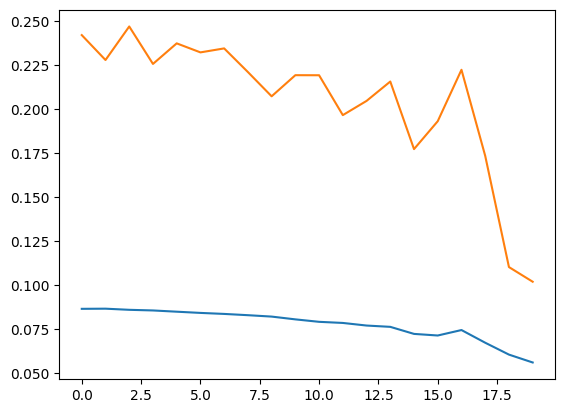

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
#plt.plot(acc)
#plt.plot(pres)

In [17]:
torch.save(model.state_dict(), '../weights/gat_2heads_128_8_knn30.pt')

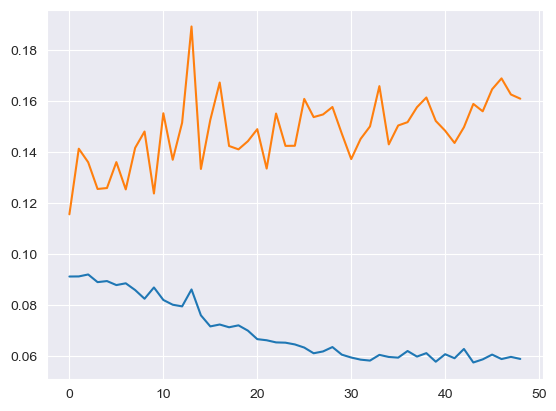

In [134]:
plt.plot(train_loss)
plt.plot(val_loss)

In [135]:
torch.save(model.state_dict(), '../weights/bs8_128_32_8_k5.pt')

In [50]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 4))

labels = [full_dataset[i].y for i in range(len(full_dataset))]

for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GCN(full_dataset.num_features, 2, channels=[256, 32, 32], dropout=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print()
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(11):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, train_pr, train_rc = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, val_pr, val_rc = eval_epoch(val_loader, model, criterion)
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        rc.append(val_rc)
        pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = np.mean(pr)
    eval_metrics[n_fold, 1] = np.mean(rc)
    eval_metrics[n_fold, 2] = np.mean(acc)
    eval_metrics[n_fold, 3] = best_test_acc


0
Epoch: 000, Train Loss: 0.0901, Test Loss 0.3478, Train Acc: 0.5714, Test Acc: 0.5000
Train Prec: 0.598, Train Rec: 0.282, Test Prec: 0.200, Test Rec: 0.200
Epoch: 001, Train Loss: 0.0906, Test Loss 0.3568, Train Acc: 0.5119, Test Acc: 0.4000
Train Prec: 0.000, Train Rec: 0.000, Test Prec: 0.000, Test Rec: 0.000
Epoch: 002, Train Loss: 0.0895, Test Loss 0.3494, Train Acc: 0.5357, Test Acc: 0.4000
Train Prec: 0.182, Train Rec: 0.053, Test Prec: 0.000, Test Rec: 0.000
Epoch: 003, Train Loss: 0.0886, Test Loss 0.3574, Train Acc: 0.5238, Test Acc: 0.4000
Train Prec: 0.091, Train Rec: 0.030, Test Prec: 0.000, Test Rec: 0.000
Epoch: 004, Train Loss: 0.0877, Test Loss 0.3517, Train Acc: 0.5595, Test Acc: 0.4000
Train Prec: 0.409, Train Rec: 0.185, Test Prec: 0.000, Test Rec: 0.000
Epoch: 005, Train Loss: 0.0884, Test Loss 0.3405, Train Acc: 0.7619, Test Acc: 0.6000
Train Prec: 0.638, Train Rec: 0.808, Test Prec: 0.600, Test Rec: 0.600
Epoch: 006, Train Loss: 0.0874, Test Loss 0.3595, Train

In [51]:
eval_metrics

array([[0.19090909, 0.19090909, 0.48181818, 0.6       ],
       [0.37272727, 0.42727273, 0.55454545, 0.6       ],
       [0.26363636, 0.29090909, 0.5       , 0.6       ],
       [0.07272727, 0.09090909, 0.42727273, 0.6       ],
       [0.3       , 0.29090909, 0.52727273, 0.6       ],
       [0.12727273, 0.12727273, 0.44545455, 0.6       ],
       [0.05454545, 0.04545455, 0.41818182, 0.4       ],
       [0.16363636, 0.19090909, 0.46363636, 0.6       ],
       [0.22727273, 0.25454545, 0.5       , 0.7       ],
       [0.23636364, 0.28181818, 0.48181818, 0.6       ]])